In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet, set_random_seed
import joblib
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError, MeanSquaredScaledError
from math import sqrt, ceil, floor

In [2]:
set_random_seed(0)

In [3]:
# importar ../Data/DatosCicloAprovisionamiento.xlsx
df_ciclo = pd.read_excel('../Data/DatosCicloAprovisionamiento.xlsx')
df_ciclo = df_ciclo.sort_values(by=['sku']).reset_index(drop=True)
df_ciclo = df_ciclo.rename(columns={'sku': 'idSku'})
df_ciclo['ciclo_aprovisionamiento'] = df_ciclo['diasEntrePedidos'] + df_ciclo['diasLeadtime']
df_ciclo.head()

idSku  diasEntrePedidos  diasLeadtime  ciclo_aprovisionamiento
0      1                18             2                       20
1      2                28             4                       32
2      3                28             2                       30
3      4                14             2                       16
4      5                14             4                       18

In [4]:
# import dataser from csv file
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [5]:
results = pd.DataFrame(columns=['idSku', 'target', 'prediction'])

In [6]:
skus = train['idSku'].unique()

for s in skus:
    train_s = train[train['idSku'] == s]
    test_s = test[test['idSku'] == s]
    sku_s = pd.concat([train_s, test_s], ignore_index=True)
    sku_s = sku_s[['idSecuencia', 'udsVenta']]
    sku_s = sku_s.rename(columns={'idSecuencia': 'ds', 'udsVenta': 'y'})

    n_forecast = df_ciclo[df_ciclo['idSku'] == s]['ciclo_aprovisionamiento'].values[0]

    path = '../Neural_prophet_models/neural_prophet_' + str(s) + '.pkl'
    m = joblib.load(path)

    forecast = m.predict(sku_s, decompose=False, raw=True)
    forecast[forecast.columns[1:]] = forecast[forecast.columns[1:]].round().astype(int)
    forecast = forecast.tail(len(test_s))
    forecast = forecast.sum(axis=1).reset_index(drop=True).tolist()

    target = sku_s['y'].rolling(n_forecast).sum()
    target = target.tail(len(test_s))
    target = target.reset_index(drop=True).tolist()

    # create a list with idSku, target and prediction
    r = pd.DataFrame([s, target, forecast]).T
    r.columns = ['idSku', 'target', 'prediction']
    results = results.append(r, ignore_index=True)

WARNING - (NP.forecaster.predict) - Raw forecasts are incompatible with plotting utilities
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\96gar\anaconda3\envs\neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\96gar\anaconda3\envs\neuralprophet\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

In [7]:
results

idSku                                             target  \
0      1  [309.0, 309.0, 306.0, 294.0, 285.0, 270.0, 294...   
1      2  [371.0, 380.0, 365.0, 356.0, 368.0, 371.0, 384...   
2      3  [190.0, 186.0, 195.0, 186.0, 186.0, 193.0, 189...   
3      4  [123.0, 123.0, 132.0, 126.0, 126.0, 123.0, 129...   
4      5  [30.0, 22.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0...   
5      6  [72.0, 75.0, 81.0, 72.0, 69.0, 72.0, 81.0, 78....   
6      7  [204.0, 210.0, 225.0, 222.0, 231.0, 237.0, 231...   
7      8  [77.0, 69.0, 69.0, 77.0, 76.0, 80.0, 85.0, 76....   
8      9  [105.0, 78.0, 78.0, 99.0, 99.0, 96.0, 93.0, 84...   
9     10  [77.0, 81.0, 78.0, 72.0, 81.0, 84.0, 96.0, 90....   
10    11  [72.0, 80.0, 80.0, 76.0, 75.0, 71.0, 65.0, 70....   
11    12  [109.0, 106.0, 101.0, 102.0, 103.0, 108.0, 114...   
12    13  [48.0, 51.0, 51.0, 57.0, 57.0, 54.0, 60.0, 60....   
13    14  [92.0, 97.0, 99.0, 109.0, 107.0, 106.0, 107.0,...   
14    15  [81.0, 102.0, 102.0, 99.0, 96.0, 99.0, 120.0, ...   
15    16  [81.0, 81.0, 72.0, 75.0, 81.0, 78.0, 84.0, 78....   
16    17  [146.0, 145.0, 143.0, 140.0, 149.0, 143.0, 144...   
17    18  [112.0, 114.0, 106.0, 115.0, 117.0, 114.0, 121...   
18    19  [45.0, 48.0, 48.0, 57.0, 63.0, 69.0, 60.0, 51....   
19    20  [214.0, 226.0, 238.0, 232.0, 232.0, 229.0, 217...   
20    21  [129.0, 138.0, 151.0, 147.0, 160.0, 158.0, 176...   
21    22  [87.0, 87.0, 93.0, 96.0, 96.0, 99.0, 111.0, 10...   
22    23  [43.0, 49.0, 53.0, 59.0, 59.0, 62.0, 61.0, 54....   
23    24  [36.0, 33.0, 33.0, 36.0, 39.0, 33.0, 48.0, 42....   
24    25  [140.0, 140.0, 137.0, 137.0, 140.0, 137.0, 143...   
25    26  [123.0, 126.0, 120.0, 105.0, 99.0, 105.0, 111....   
26    27  [42.0, 46.0, 47.0, 51.0, 55.0, 53.0, 54.0, 47....   
27    28  [113.0, 111.0, 112.0, 117.0, 124.0, 125.0, 123...   
28    29  [87.0, 90.0, 105.0, 99.0, 114.0, 111.0, 111.0,...   
29    30  [75.0, 78.0, 81.0, 81.0, 81.0, 75.0, 84.0, 81....   
30    31  [42.0, 36.0, 36.0, 36.0, 39.0, 42.0, 48.0, 48....   
31    32  [84.0, 87.0, 90.0, 84.0, 81.0, 87.0, 96.0, 87....   
32    33  [82.0, 82.0, 94.0, 91.0, 91.0, 88.0, 103.0, 10...   
33    34  [102.0, 102.0, 105.0, 99.0, 99.0, 99.0, 102.0,...   
34    35  [50.0, 62.0, 65.0, 71.0, 65.0, 71.0, 71.0, 62....   
35    36  [31.0, 35.0, 35.0, 36.0, 35.0, 31.0, 30.0, 23....   
36    37  [36.0, 48.0, 54.0, 60.0, 54.0, 48.0, 48.0, 45....   
37    38  [21.0, 24.0, 24.0, 21.0, 24.0, 24.0, 24.0, 21....   
38    39  [60.0, 58.0, 59.0, 61.0, 62.0, 64.0, 66.0, 60....   
39    40  [111.0, 123.0, 129.0, 132.0, 123.0, 132.0, 135...   
40    41  [63.0, 60.0, 54.0, 57.0, 63.0, 57.0, 66.0, 66....   
41    42  [57.0, 57.0, 60.0, 58.0, 52.0, 58.0, 61.0, 54....   
42    43  [99.0, 93.0, 93.0, 87.0, 87.0, 78.0, 84.0, 81....   
43    44  [105.0, 103.0, 103.0, 91.0, 88.0, 91.0, 100.0,...   
44    45  [90.0, 96.0, 96.0, 108.0, 90.0, 96.0, 102.0, 9...   
45    46  [72.0, 72.0, 88.0, 87.0, 96.0, 105.0, 108.0, 1...   
46    47  [125.0, 131.0, 122.0, 122.0, 125.0, 117.0, 109...   
47    48  [81.0, 84.0, 87.0, 84.0, 93.0, 90.0, 90.0, 87....   
48    49  [143.0, 141.0, 148.0, 141.0, 156.0, 164.0, 162...   
49    50  [82.0, 88.0, 82.0, 82.0, 79.0, 91.0, 96.0, 90....   

                                           prediction  
0   [331, 342, 330, 306, 350, 317, 325, 377, 389, ...  
1   [417, 440, 435, 433, 417, 416, 417, 416, 424, ...  
2   [91, 93, 88, 84, 80, 76, 71, 66, 67, 62, 58, 5...  
3   [105, 112, 109, 113, 123, 107, 102, 122, 133, ...  
4   [-65, -79, -84, -91, -80, -87, -93, -107, -122...  
5   [114, 130, 114, 118, 119, 121, 116, 114, 130, ...  
6   [136, 140, 135, 130, 126, 121, 114, 113, 116, ...  
7   [73, 79, 78, 71, 71, 71, 73, 73, 79, 78, 71, 7...  
8   [108, 121, 125, 130, 134, 135, 118, 118, 132, ...  
9   [27, 29, 29, 24, 18, 17, 20, 20, 19, 15, 15, 1...  
10  [78, 84, 83, 83, 76, 76, 81, 73, 81, 85, 86, 7...  
11  [125, 127, 127, 130, 127, 128, 126, 127, 129, ...  
12  [26, 32, 24, 22, 20, 25, 18, 17, 19, 25, 17, 1...  
13  [

In [8]:
# RMSE: Root Mean Squared Error
# MAPE: Mean Absolute Percentage Error
# MASE: Mean Absolute Scaled Error
# SMAPE: Symmetric Mean Absolute Percentage Error
# RMSSE: Root Mean Squared Scaled Error

results['RMSE'] = np.nan
results['MAPE'] = np.nan
results['MASE'] = np.nan
results['SMAPE'] = np.nan
results['RMSSE'] = np.nan

rmse = MeanSquaredError(square_root=True)
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()
smape = MeanAbsolutePercentageError(symmetric=True)
rmsse = MeanSquaredScaledError(square_root=True)

# calculate rmse for each sku and append to results dataframe
for i in range(0, 50):
    t = pd.Series(results['target'][i])
    p = pd.Series(results['prediction'][i])
    y_train = train[train['idSku'] == i+1]['udsVenta']
    results['RMSE'][i] = rmse(t, p)
    results['MAPE'][i] = mape(t, p)
    results['MASE'][i] = mase(t, p, y_train=y_train)
    results['SMAPE'][i] = smape(t, p)
    results['RMSSE'][i] = rmsse(t, p, y_train=y_train)
results

WARNING - (py.warnings._showwarnmsg) - C:\Users\96gar\AppData\Local\Temp\ipykernel_9988\2379025414.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['RMSE'][i] = rmse(t, p)

WARNING - (py.warnings._showwarnmsg) - C:\Users\96gar\AppData\Local\Temp\ipykernel_9988\2379025414.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['MAPE'][i] = mape(t, p)

WARNING - (py.warnings._showwarnmsg) - C:\Users\96gar\AppData\Local\Temp\ipykernel_9988\2379025414.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

idSku                                             target  \
0      1  [309.0, 309.0, 306.0, 294.0, 285.0, 270.0, 294...   
1      2  [371.0, 380.0, 365.0, 356.0, 368.0, 371.0, 384...   
2      3  [190.0, 186.0, 195.0, 186.0, 186.0, 193.0, 189...   
3      4  [123.0, 123.0, 132.0, 126.0, 126.0, 123.0, 129...   
4      5  [30.0, 22.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0...   
5      6  [72.0, 75.0, 81.0, 72.0, 69.0, 72.0, 81.0, 78....   
6      7  [204.0, 210.0, 225.0, 222.0, 231.0, 237.0, 231...   
7      8  [77.0, 69.0, 69.0, 77.0, 76.0, 80.0, 85.0, 76....   
8      9  [105.0, 78.0, 78.0, 99.0, 99.0, 96.0, 93.0, 84...   
9     10  [77.0, 81.0, 78.0, 72.0, 81.0, 84.0, 96.0, 90....   
10    11  [72.0, 80.0, 80.0, 76.0, 75.0, 71.0, 65.0, 70....   
11    12  [109.0, 106.0, 101.0, 102.0, 103.0, 108.0, 114...   
12    13  [48.0, 51.0, 51.0, 57.0, 57.0, 54.0, 60.0, 60....   
13    14  [92.0, 97.0, 99.0, 109.0, 107.0, 106.0, 107.0,...   
14    15  [81.0, 102.0, 102.0, 99.0, 96.0, 99.0, 120.0, ...   
15    16  [81.0, 81.0, 72.0, 75.0, 81.0, 78.0, 84.0, 78....   
16    17  [146.0, 145.0, 143.0, 140.0, 149.0, 143.0, 144...   
17    18  [112.0, 114.0, 106.0, 115.0, 117.0, 114.0, 121...   
18    19  [45.0, 48.0, 48.0, 57.0, 63.0, 69.0, 60.0, 51....   
19    20  [214.0, 226.0, 238.0, 232.0, 232.0, 229.0, 217...   
20    21  [129.0, 138.0, 151.0, 147.0, 160.0, 158.0, 176...   
21    22  [87.0, 87.0, 93.0, 96.0, 96.0, 99.0, 111.0, 10...   
22    23  [43.0, 49.0, 53.0, 59.0, 59.0, 62.0, 61.0, 54....   
23    24  [36.0, 33.0, 33.0, 36.0, 39.0, 33.0, 48.0, 42....   
24    25  [140.0, 140.0, 137.0, 137.0, 140.0, 137.0, 143...   
25    26  [123.0, 126.0, 120.0, 105.0, 99.0, 105.0, 111....   
26    27  [42.0, 46.0, 47.0, 51.0, 55.0, 53.0, 54.0, 47....   
27    28  [113.0, 111.0, 112.0, 117.0, 124.0, 125.0, 123...   
28    29  [87.0, 90.0, 105.0, 99.0, 114.0, 111.0, 111.0,...   
29    30  [75.0, 78.0, 81.0, 81.0, 81.0, 75.0, 84.0, 81....   
30    31  [42.0, 36.0, 36.0, 36.0, 39.0, 42.0, 48.0, 48....   
31    32  [84.0, 87.0, 90.0, 84.0, 81.0, 87.0, 96.0, 87....   
32    33  [82.0, 82.0, 94.0, 91.0, 91.0, 88.0, 103.0, 10...   
33    34  [102.0, 102.0, 105.0, 99.0, 99.0, 99.0, 102.0,...   
34    35  [50.0, 62.0, 65.0, 71.0, 65.0, 71.0, 71.0, 62....   
35    36  [31.0, 35.0, 35.0, 36.0, 35.0, 31.0, 30.0, 23....   
36    37  [36.0, 48.0, 54.0, 60.0, 54.0, 48.0, 48.0, 45....   
37    38  [21.0, 24.0, 24.0, 21.0, 24.0, 24.0, 24.0, 21....   
38    39  [60.0, 58.0, 59.0, 61.0, 62.0, 64.0, 66.0, 60....   
39    40  [111.0, 123.0, 129.0, 132.0, 123.0, 132.0, 135...   
40    41  [63.0, 60.0, 54.0, 57.0, 63.0, 57.0, 66.0, 66....   
41    42  [57.0, 57.0, 60.0, 58.0, 52.0, 58.0, 61.0, 54....   
42    43  [99.0, 93.0, 93.0, 87.0, 87.0, 78.0, 84.0, 81....   
43    44  [105.0, 103.0, 103.0, 91.0, 88.0, 91.0, 100.0,...   
44    45  [90.0, 96.0, 96.0, 108.0, 90.0, 96.0, 102.0, 9...   
45    46  [72.0, 72.0, 88.0, 87.0, 96.0, 105.0, 108.0, 1...   
46    47  [125.0, 131.0, 122.0, 122.0, 125.0, 117.0, 109...   
47    48  [81.0, 84.0, 87.0, 84.0, 93.0, 90.0, 90.0, 87....   
48    49  [143.0, 141.0, 148.0, 141.0, 156.0, 164.0, 162...   
49    50  [82.0, 88.0, 82.0, 82.0, 79.0, 91.0, 96.0, 90....   

                                           prediction        RMSE  \
0   [331, 342, 330, 306, 350, 317, 325, 377, 389, ...  161.246027   
1   [417, 440, 435, 433, 417, 416, 417, 416, 424, ...   91.523520   
2   [91, 93, 88, 84, 80, 76, 71, 66, 67, 62, 58, 5...  402.493857   
3   [105, 112, 109, 113, 123, 107, 102, 122, 133, ...   39.026934   
4   [-65, -79, -84, -91, -80, -87, -93, -107, -122...  726.782308   
5   [114, 130, 114, 118, 119, 121, 116, 114, 130, ...   46.402451   
6   [136, 140, 135, 130, 126, 121, 114, 113, 116, ...  322.837783   
7   [73, 79, 78, 71, 71, 71, 73, 73, 79, 78, 71, 7...   25.723895   
8   [108, 121, 125, 130, 134, 135, 118, 118, 132, ...  113.512045   
9   [27, 29, 29, 24, 18, 17, 20, 20, 19, 15, 15, 1...   99.479505   
10  [78, 84, 83, 83, 76, 76, 8

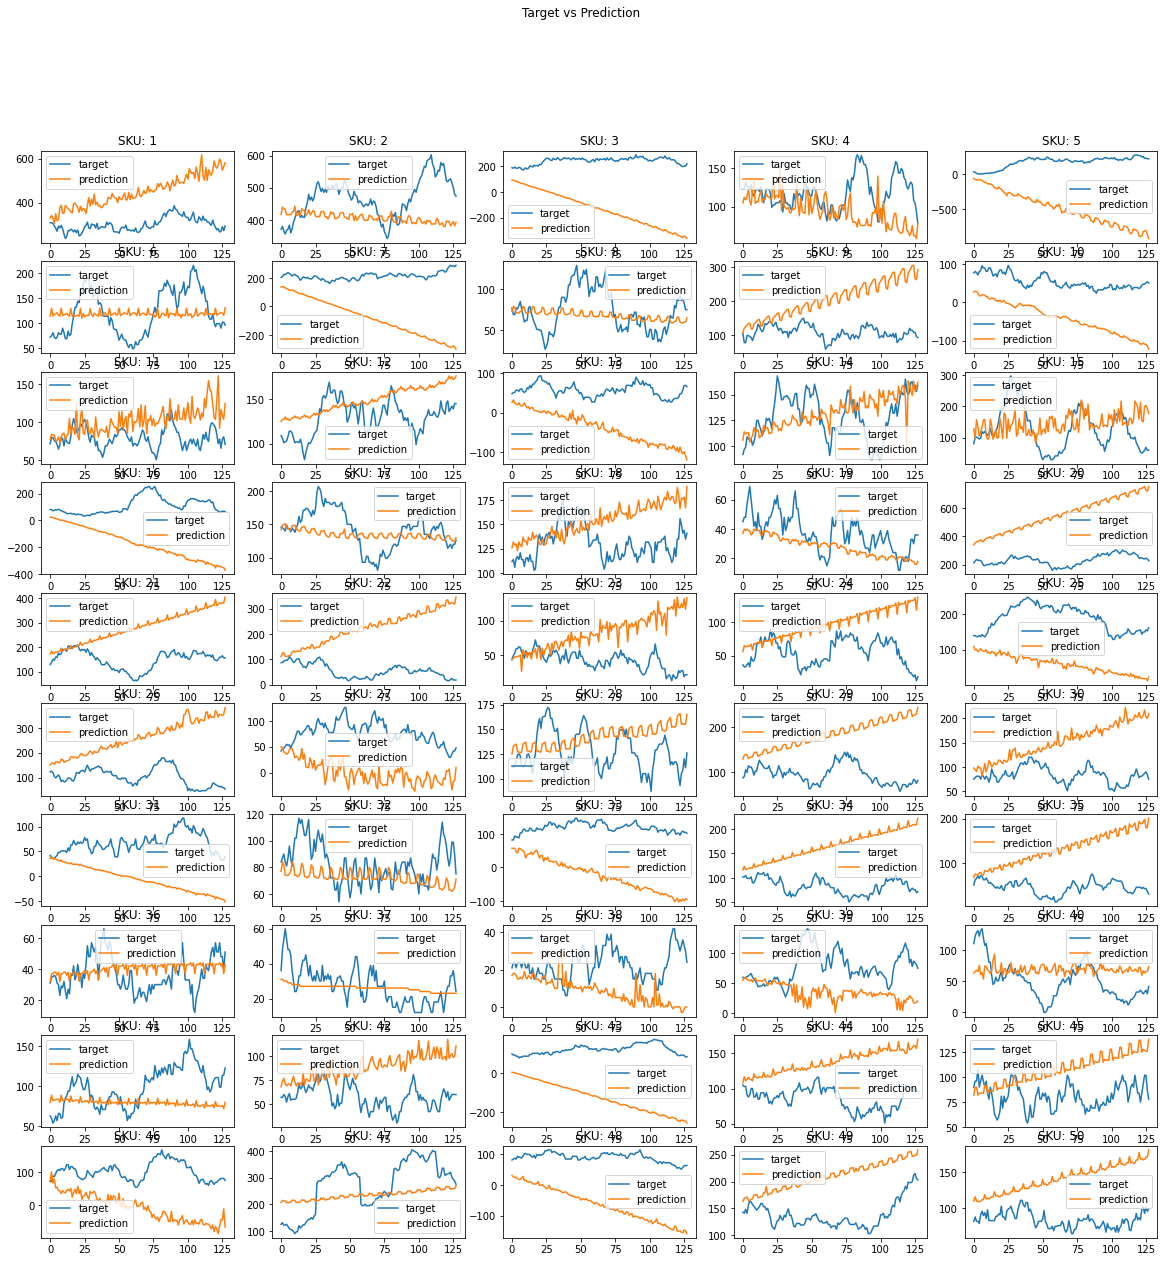

In [9]:
# make 50 subplots in a 10x5 grid and plot the target and prediction
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
fig.suptitle('Target vs Prediction')
for i in range(10):
    for j in range(5):
        axs[i, j].plot(results['target'][i*5+j], label='target')
        axs[i, j].plot(results['prediction'][i*5+j], label='prediction')
        axs[i, j].legend()
        axs[i, j].set_title('SKU: ' + str(i*5+j+1))
plt.show()

In [10]:
# get the metrics of the results dataframe
metrics = results[['RMSE', 'MAPE', 'MASE', 'SMAPE', 'RMSSE']]

# get the mean of each metric
metrics_mean = metrics.mean()
metrics_mean

RMSE     1.110370e+02
MAPE     4.236198e+14
MASE     1.700816e+01
SMAPE    7.993801e-01
RMSSE    1.421981e+01
dtype: float64

In [11]:
df_precio = pd.read_excel('../Data/DatosPrecioMedio.xlsx')
df_precio = df_precio.rename(columns={'idSkuIta': 'idSku'})
df_precio = df_precio.sort_values(by=['idSku']).reset_index(drop=True)
df_precio.head()

idSku  eurPrecioMedio
0      1        1.370002
1      2        1.370002
2      3        1.370002
3      4        1.370002
4      5        1.370002

In [12]:
df_ciclo = df_ciclo.merge(df_precio, on='idSku', how='inner')
df_ciclo = df_ciclo.merge(results[['idSku', 'RMSE']], on='idSku', how='inner')
df_ciclo.head()

idSku  diasEntrePedidos  diasLeadtime  ciclo_aprovisionamiento  \
0     1                18             2                       20   
1     2                28             4                       32   
2     3                28             2                       30   
3     4                14             2                       16   
4     5                14             4                       18   

   eurPrecioMedio        RMSE  
0        1.370002  161.246027  
1        1.370002   91.523520  
2        1.370002  402.493857  
3        1.370002   39.026934  
4        1.370002  726.782308

In [13]:
factor = 1.64
df_ciclo['stock_seguridad'] = df_ciclo.apply(lambda x: ceil(factor * x['RMSE'] * sqrt(x['ciclo_aprovisionamiento'])), axis=1)
df_ciclo.head()

idSku  diasEntrePedidos  diasLeadtime  ciclo_aprovisionamiento  \
0     1                18             2                       20   
1     2                28             4                       32   
2     3                28             2                       30   
3     4                14             2                       16   
4     5                14             4                       18   

   eurPrecioMedio        RMSE  stock_seguridad  
0        1.370002  161.246027             1183  
1        1.370002   91.523520              850  
2        1.370002  402.493857             3616  
3        1.370002   39.026934              257  
4        1.370002  726.782308             5057

In [14]:
df_ciclo['coste_stock_diario'] = df_ciclo.apply(lambda x: 0.05 * x['eurPrecioMedio'] * x['stock_seguridad'], axis=1)
df_ciclo.head()

idSku  diasEntrePedidos  diasLeadtime  ciclo_aprovisionamiento  \
0     1                18             2                       20   
1     2                28             4                       32   
2     3                28             2                       30   
3     4                14             2                       16   
4     5                14             4                       18   

   eurPrecioMedio        RMSE  stock_seguridad  coste_stock_diario  
0        1.370002  161.246027             1183           81.035593  
1        1.370002   91.523520              850           58.225067  
2        1.370002  402.493857             3616          247.696284  
3        1.370002   39.026934              257           17.604520  
4        1.370002  726.782308             5057          346.404897

In [15]:
# save df_ciclo to excel file
df_ciclo.to_excel('../Data/Neural_prophet_stock_cost.xlsx', index=False)

In [25]:
coste_stock_diario_total = df_ciclo['coste_stock_diario'].sum().round(2)
coste_stock_diario_anual = coste_stock_diario_total * 365

print('Coste stock total diario: {}€'.format(coste_stock_diario_total))
print('Coste stock total anual: {}€'.format(coste_stock_diario_anual))

Coste stock total diario: 6213.49€
Coste stock total anual: 2267923.85€
